### Exercise 1.1: A baseline MLP

In [103]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F # Contiene una versione funzionale di molti layer. 
import torchvision.transforms as transforms
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [104]:
# Hyperparameters
eval_percentage = 0.3
lr = 0.0001
opt = 'Adam'
loss = 'CrossEntropy'
epochs = 25
#layers = [28*28, 64, 64, 64, 10]
layers = [28*28, 64, 64, 64, 10]
batch_size = 64



In [105]:
# Data import
def import_MNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Numeri per fare la standardizzazione di MNIST si ottengono come sotto
    ])
    
    
    
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    eval_size = round(eval_percentage*(len(train_data)))
    eval_data = Subset(train_data, range(eval_size))
    train_data = Subset(train_data, range(eval_size, len(train_data)))
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
    evaluation   = torch.utils.data.DataLoader(eval_data, batch_size, num_workers=4)
    test  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=4)

    
    return train, evaluation, test

In [106]:
class simpleMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

In [107]:
model1 = simpleMLP(layers)
print(model1)

simpleMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-1): ReLU()
    (layer-2): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-2): ReLU()
    (layer-3): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Riscrivere plot

In [108]:
def evaluate(model, dataset, device='cpu', test=False):
    model.eval()
    predictions = []
    ground_truth = [] 
    for (value, label) in tqdm(dataset, desc='Evaluating', leave=True):
        value = value.to(device)
        prediction = torch.argmax(model(value), dim=1)

        ground_truth = np.append(ground_truth, label.cpu().numpy())  
        predictions = np.append(predictions, prediction.detach().cpu().numpy()) 


    accuracy = accuracy_score(ground_truth, predictions)
    report = classification_report(ground_truth, predictions, zero_division=0, digits=3)
        
    
    return (accuracy, report)

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

In [109]:
def train_batch(epoch, model, optimizer, loss_fn, train_data, device, writer):
    losses = []
    for (value, label) in tqdm(train_data, desc=f'Training epoch {epoch}', leave=True):
        value = value.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        prediction = model(value)
        
        # Choose loss function
        if loss == 'CrossEntropy':
            loss_fn = nn.CrossEntropyLoss()
            
        loss_value = loss_fn(prediction, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())

        writer.add_scalar('Loss/train', np.mean(losses), epoch)
        
    return np.mean(losses)

def train_model(model, optimizer, loss, epochs, train_data, eval_data, device, writer):
    model.train()
    losses_and_accs = []
    for epoch in range(epochs):
        loss_value = train_batch(epoch, model, optimizer, loss, train_data, device, writer)
        (accuracy, _) = evaluate(model, eval_data, device)
        losses_and_accs.append((loss_value, accuracy))
        #losses_and_accs.append(loss_value)
        writer.add_scalar('Accuracy/train', accuracy, epoch)
    return losses_and_accs

            

In [110]:
# Main function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()


# Instance of the model
model = simpleMLP(layers)
model.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter(log_dir=f"runs/MNIST-model='MLP'-lr={lr}-opt={opt}-loss={loss}-epochs={epochs}-batch_size={batch_size}-layers={layers}")

losses_and_accs = train_model(model, optimizer, loss, epochs, train_data, eval_data, device, writer)



Evaluating: 100%|████████████████████████████| 282/282 [00:02<00:00, 120.65it/s]


0.06937493404580487


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 71.05it/s]

Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.971     0.990     0.980       980
         1.0      0.981     0.986     0.983      1135
         2.0      0.958     0.974     0.966      1032
         3.0      0.955     0.978     0.966      1010
         4.0      0.957     0.973     0.965       982
         5.0      0.974     0.950     0.961       892
         6.0      0.969     0.975     0.972       958
         7.0      0.979     0.958     0.969      1028
         8.0      0.958     0.952     0.955       974
         9.0      0.974     0.937     0.955      1009

    accuracy                          0.968     10000
   macro avg      0.967     0.967     0.967     10000
weighted avg      0.968     0.968     0.967     10000



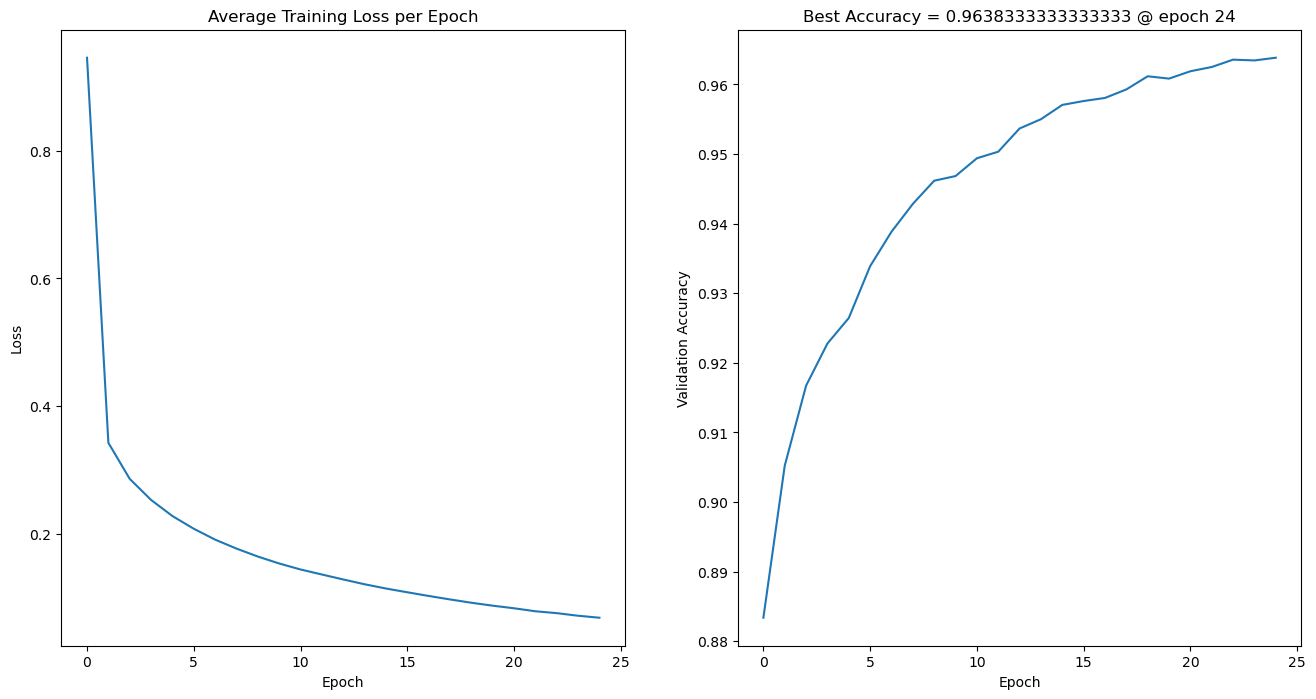

In [111]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [112]:
# Non funziona se i layer intermedi hanno dimensioni diverse. Risolvere
class skipMLPBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, out_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(out_size, in_size)

    def forward(self, x):
        out1 = self.layer1(x)
        out1_relu = self.relu1(out1)
        out2 = self.layer2(out1_relu)

        out = x + out2
            
        return out

class skipMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        
        for i in range(len(layer_sizes)-1):
            if i == 0:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            elif i == len(layer_sizes)-2:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            else:
                self.layers.add_module(f'layer-{i}', skipMLPBlock(layer_sizes[i], layer_sizes[i+1]))
                if layer_sizes[i] != layer_sizes[i+1]:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())
                    self.layers.add_module(f'layer-bridge{i}-{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                    self.layers.add_module(f'Nonlinearity-bridge{i}-{i+1}', nn.ReLU())
            if i < len(layer_sizes)-2:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

modelres = skipMLP(layers)
print(modelres)

skipMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): skipMLPBlock(
      (layer1): Linear(in_features=64, out_features=64, bias=True)
      (relu1): ReLU()
      (layer2): Linear(in_features=64, out_features=64, bias=True)
    )
    (Nonlinearity-layer-1): ReLU()
    (layer-2): skipMLPBlock(
      (layer1): Linear(in_features=64, out_features=64, bias=True)
      (relu1): ReLU()
      (layer2): Linear(in_features=64, out_features=64, bias=True)
    )
    (Nonlinearity-layer-2): ReLU()
    (layer-3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [113]:
# Main function 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
modelskip = skipMLP(layers)
modelskip.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(modelskip.parameters(), lr=lr)
    
writer = SummaryWriter(log_dir=f"runs/MNIST-model='skipMLP'-lr={lr}-opt={opt}-loss={loss}-epochs={epochs}-batch_size={batch_size}-layers={layers}")

losses_and_accs = train_model(modelskip, optimizer, loss, epochs, train_data, eval_data, device, writer)

Evaluating: 100%|████████████████████████████| 282/282 [00:02<00:00, 119.30it/s]


0.03133360541526999


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 69.84it/s]

Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.971     0.990     0.980       980
         1.0      0.981     0.986     0.983      1135
         2.0      0.958     0.974     0.966      1032
         3.0      0.955     0.978     0.966      1010
         4.0      0.957     0.973     0.965       982
         5.0      0.974     0.950     0.961       892
         6.0      0.969     0.975     0.972       958
         7.0      0.979     0.958     0.969      1028
         8.0      0.958     0.952     0.955       974
         9.0      0.974     0.937     0.955      1009

    accuracy                          0.968     10000
   macro avg      0.967     0.967     0.967     10000
weighted avg      0.968     0.968     0.967     10000



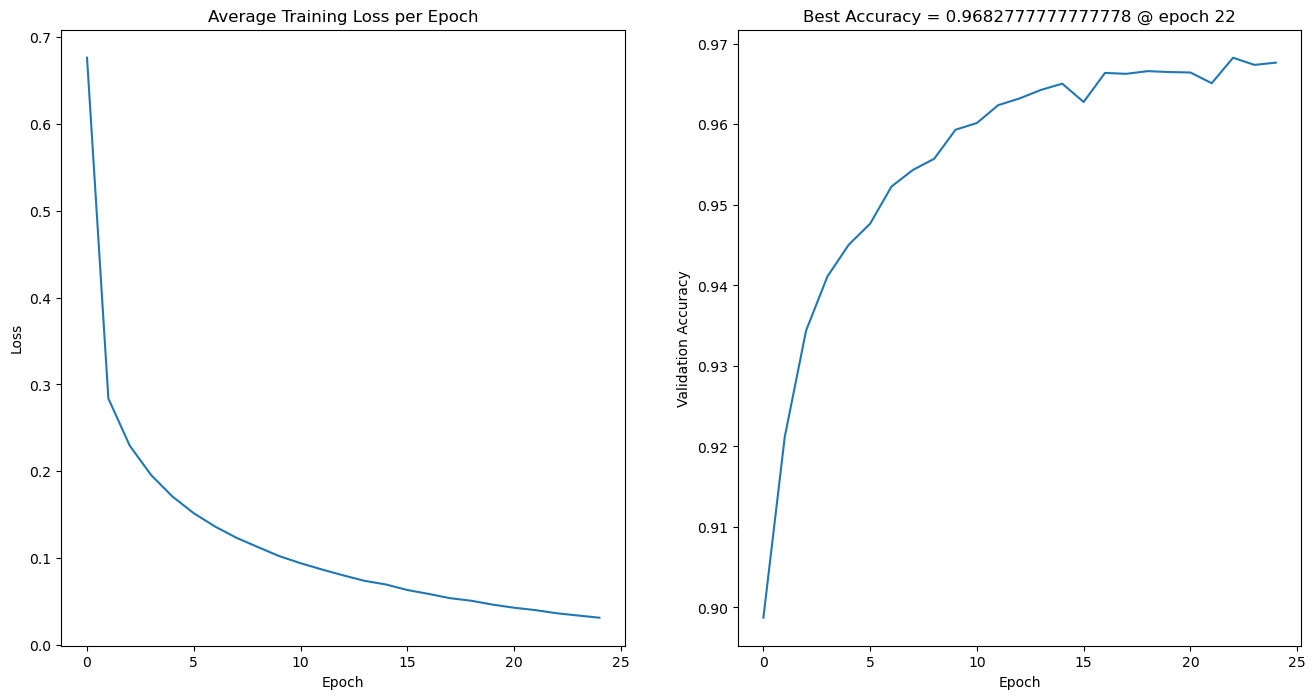

In [114]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [115]:

#layers = [32, 64, 64, 64, 64, 10]

class simpleCONV(nn.Module):
    def __init__(self, layer_sizes, size=28, in_channels=1, kernel_size=3, stride=1, padding=1):
        super().__init__()
        countMaxPools = 0
        self.layers = nn.Sequential()
        
        #self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-2):
            self.layers.add_module(f'layer-{i}', nn.Conv2d(in_channels, layer_sizes[i], kernel_size, stride, padding))
            in_channels = layer_sizes[i]
            if i == 0:
                self.layers.add_module(f'MaxPool-{i}', nn.MaxPool2d(kernel_size=2, stride=2))
                countMaxPools = countMaxPools + 1
            if i == int((len(layer_sizes)-1)/2):
                self.layers.add_module(f'MaxPool-{i}', nn.MaxPool2d(kernel_size=2, stride=2))
                countMaxPools = countMaxPools + 1
            if i < len(layer_sizes)-3:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())
        if countMaxPools !=0:
            size = int(size/(2*countMaxPools))
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        self.layers.add_module(f'linear-layer', nn.Linear(layer_sizes[-2]*size*size, layer_sizes[-1]))
     
    def forward(self, x):
        return self.layers(x)



# Implementare anche fullyCONV


In [116]:
# Main function 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
modelconv = simpleCONV(layers)
modelconv.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(modelconv.parameters(), lr=lr)

writer = SummaryWriter(log_dir=f"runs/MNIST-model='simpleCONV'-lr={lr}-opt={opt}-loss={loss}-epochs={epochs}-batch_size={batch_size}-layers={layers}")

losses_and_accs = train_model(modelconv, optimizer, loss, epochs, train_data, eval_data, device, writer)

Evaluating: 100%|█████████████████████████████| 282/282 [00:37<00:00,  7.56it/s]


0.0026895056160908377


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 58.31it/s]

Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.971     0.990     0.980       980
         1.0      0.981     0.986     0.983      1135
         2.0      0.958     0.974     0.966      1032
         3.0      0.955     0.978     0.966      1010
         4.0      0.957     0.973     0.965       982
         5.0      0.974     0.950     0.961       892
         6.0      0.969     0.975     0.972       958
         7.0      0.979     0.958     0.969      1028
         8.0      0.958     0.952     0.955       974
         9.0      0.974     0.937     0.955      1009

    accuracy                          0.968     10000
   macro avg      0.967     0.967     0.967     10000
weighted avg      0.968     0.968     0.967     10000



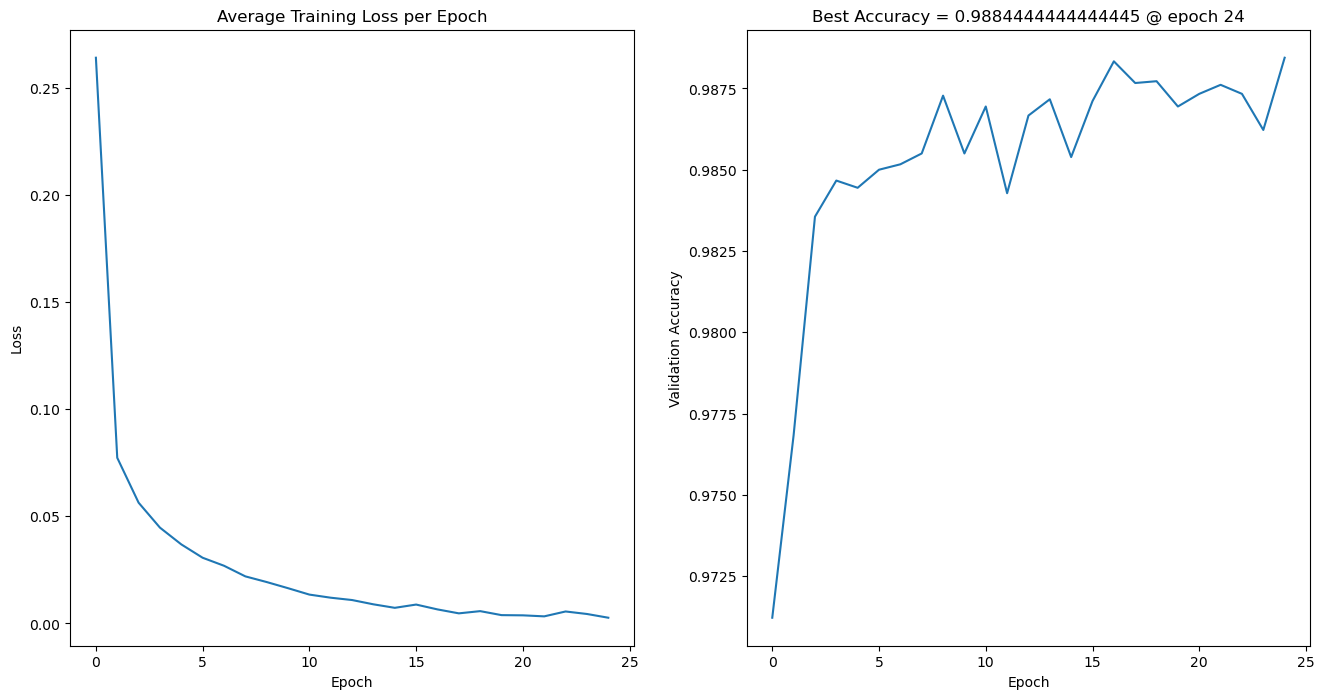

In [117]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')